# Plotting detections

In [21]:
from os import listdir
from os.path import isfile, join
from natsort import natsorted, ns
from PIL import Image
import numpy as np
import os

from PIL import Image

import tools.dataset_tools as dataset_tools
from tools.frame_pb2 import Frame
import tools.plot_tools as plot_tools

In [22]:
import pickle
        
with open('output_data.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
    
        
converted_dets_p = {}
for key in loaded_dict:
    converted_dets_p[key] = []
    for detection in loaded_dict[key][0][1]:
        _score, _x, _y, _z, _h, _w, _l, _yaw = detection
        x = _y / 615 * 50
        y = _x / 615 * 40 - 20
        w = _w / 615 * 50 + 1.5
        l = _l / 615 * 40 + 2.5
        converted_dets_p[key].append([_score, x, y, _z, _h, w, l, _yaw] )

In [23]:
frame_n = 100

In [24]:
frame = dataset_tools.read_frame(f"data_2/frame_{frame_n}.pb")
camera = frame.cameras[0]
img = dataset_tools.decode_img(camera)
image = Image.fromarray(img)
lidar = frame.lidars[0]


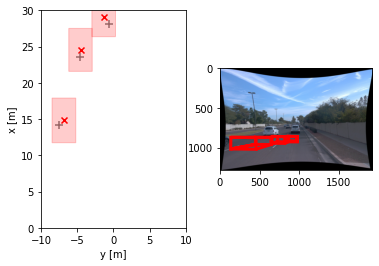

In [25]:
import numpy as np

class Track2:
    
    def __init__(self, detection):
        self.x = np.asarray([detection[1], detection[2], detection[3]])
        self.h = detection[4]
        self.w = detection[5]
        self.l = detection[6]
        self.yaw = detection[7]
        self.state = "initialized"
        self.id = ""


tracks = [Track2(detection) for detection in converted_dets_p[frame_n]]
tracks_ = [detection for detection in lidar.detections if detection.pos[0]>0 and detection.pos[0]<50]
plot_tools.plot_tracks(img,tracks,[], tracks_, camera)

# Calculating metrics

In [26]:
mypath = "data_2/"
onlyfiles = natsorted([mypath+f for f in listdir(mypath) if isfile(join(mypath, f))], key=lambda y: y.lower())

In [27]:
def get_lidar(frame_path):
    frame = dataset_tools.read_frame(frame_path)
    lidar = frame.lidars[0]
    return lidar

In [28]:
converted_gt = {}
for key in range(len(onlyfiles)):
    lidar = get_lidar(onlyfiles[key])
    converted_gt[key] = []
    for detection in lidar.detections:
        if detection.pos[0]>0 and detection.pos[0]<50:  
            converted_gt[key].append([detection.pos[0], detection.pos[1],
                                      detection.pos[2], detection.scale[2], 
                                      detection.scale[1], detection.scale[0], detection.rot[2]])

In [29]:
import pickle
with open('output_data.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [30]:
converted_dets = {}
for key in loaded_dict:
    converted_dets[key] = []
    for detection in loaded_dict[key][0][1]:
        _score, _x, _y, _z, _h, _w, _l, _yaw = detection
        x = _y / 640 * 50
        y = _x / 640 * 20 - 7.5
        w = _w / 640 * 50 + 1.4
        l = _l / 640 * 20 + 2.5
        converted_dets[key].append([x, y, _z, _h, w, l, _yaw] )


### Here we get the boxes for the ground truth

In [31]:
boxes_gt = {}
for k in converted_gt:
    boxes_gt[k] = []
    points_frame = converted_gt[k]
    for p in points_frame:
        _x, _y, _z, _h, _w, _l, _yaw = p
        x = - _y
        y = _x
        w = x + _w
        l = y + _l
        boxes_gt[k].append([x, y, w, l])
        

### Here we get the boxes for our detection

In [32]:
boxes_dt = {}
for k in converted_dets:
    boxes_dt[k] = []
    points_frame = converted_dets[k]
    for p in points_frame:
        _x, _y, _z, _h, _w, _l, _yaw = p
        x = - _y
        y = _x
        w = x + _w
        l = y + _l
        boxes_dt[k].append([x, y, w, l])

In [33]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    #print(boxA)
    #print(boxB)
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    #print(xA,yA,xB,yB)
    # compute the area of intersection rectangle
    if (xB - xA) > 0 and (yB - yA) > 0:
        interArea =(xB - xA) * (yB - yA)
    else:
        interArea = 0
    #print(xB - xA)
    #print(yB - yA)
    #print(interArea)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs(boxA[2] - boxA[0]) * abs(boxA[3] - boxA[1])
    boxBArea = abs(boxB[2] - boxB[0]) * abs(boxB[3] - boxB[1])
    #print(boxAArea,boxBArea)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

def get_metrics_per_frame(f_detections_gt,f_detections_output):
    n_detections_gt = len(f_detections_gt)
    n_detections_output = len(f_detections_output)
    #print('n_detections_gt:', n_detections_gt)
    #print('f_detections_output:', n_detections_output)
    fn = 0
    if n_detections_gt > n_detections_output:
        fn = n_detections_gt - n_detections_output

    frame_iou = []
    for i in f_detections_output:
        max_iou = 0
        for j in f_detections_gt:
            t_iou = bb_intersection_over_union(i,j)
            if t_iou > max_iou :
                max_iou = t_iou
        frame_iou.append(max_iou)

    tp = len([i for i in frame_iou if i >= 0.5])
    fp = len([i for i in frame_iou if i < 0.5])

    precision = tp / (tp + fp)
    if (tp + fn) > 0:
        recall = tp / (tp + fn)
    else:
        recall = 0
    
    return precision,recall

In [34]:
precision = {}
recall= {}
for i in range(len(boxes_gt)):
    p,r = get_metrics_per_frame(boxes_gt[i],boxes_dt[i])
    precision[i]= p
    recall[i]= r


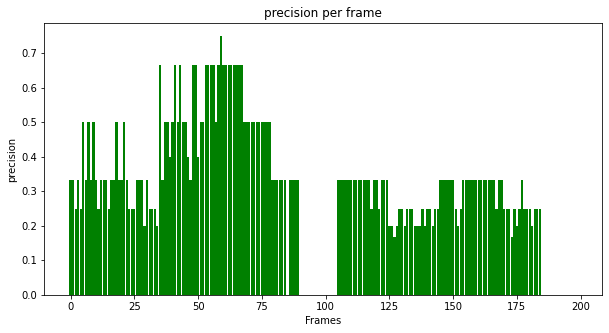

In [35]:
import numpy as np
import matplotlib.pyplot as plt
  
fig = plt.figure(figsize = (10, 5))
courses = list(precision.keys())
values = list(precision.values())
# creating the bar plot
plt.bar(courses, values, color ='green',width = 0.9)
 
plt.xlabel("Frames")
plt.ylabel("precision")
plt.title("precision per frame")
plt.show()

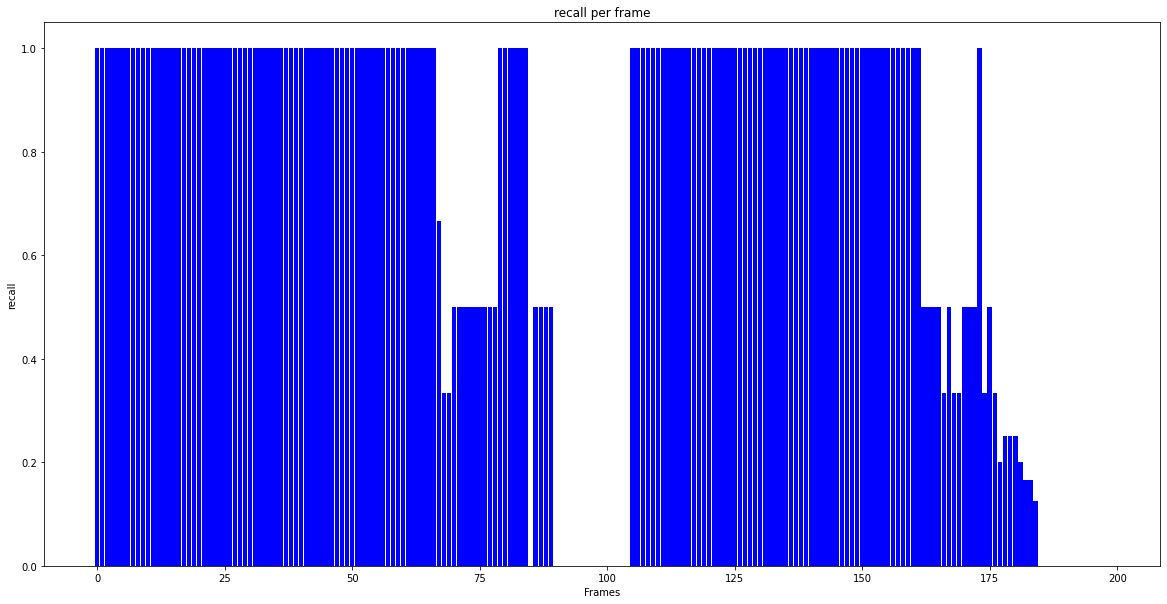

In [36]:
fig = plt.figure(figsize = (20, 10))
courses = list(recall.keys())
values = list(recall.values())
# creating the bar plot
plt.bar(courses, values, color ='blue',width = 0.9)
 
plt.xlabel("Frames")
plt.ylabel("recall")
plt.title("recall per frame")
plt.show()

### Mean precision

In [37]:
p_values = np.array([precision[i] for i in precision])

p_values.mean()

0.31113902847571184

### Mean recall

In [38]:
r_values = np.array([recall[i] for i in recall])

r_values.mean()

0.7367252931323284

Althought the metrics in the detections seems not as precise we believe it's to the rescaling of the detections, because when comparing to the plotting we see that our detections are not as far off 